In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from os.path import join
from os import environ

In [2]:
Autoencoder = tf.keras.models.load_model('k_fold_best_model_new_architecture_test3')

In [3]:
home=environ['HOME']
folder1='GRIMech_CH4_models_RS3_15_trajectories'
folder2='Datasets'

cantera_species=pd.read_csv(join(home, folder1,folder2,'State_space_cte_pressure_T1418_st-quarter_phi_0.csv'))
cantera_species=pd.DataFrame(cantera_species)

cantera_sources=pd.read_csv(join(home,folder1,folder2,'Reaction_rates_cte_pressure_T1418_st-quarter_phi_0.csv'))
cantera_sources=pd.DataFrame(cantera_sources)

maximum_values=pd.read_csv(join(home,folder1,folder2,'maximum_values_T1418.csv'))
maximum_values=pd.DataFrame(maximum_values)

In [4]:
def hydrogen_data_clean_shift_grimech_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:]
    print(np.shape(cantera_species_fractions))
    
    cantera_species_fractions=cantera_species_fractions.loc[:,(cantera_species!=0).any(axis=0)]
    cantera_species_fractions=cantera_species_fractions.loc[:, (cantera_species != cantera_species.iloc[0]).any()]
    print(np.shape(cantera_species_fractions))
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    print(n_columns_mass_fraction)
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    print(np.shape(cantera_sources))
    n_columns_source=np.shape(cantera_sources)[1]
    print(n_columns_source)
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[:,1:]
    maximum_values=pd.concat([maximum_values.iloc[:,0:2],maximum_values.iloc[:,3:]],axis=1)
    #print(maximum_values)
    
    maximum_values=maximum_values.to_numpy()
    #print(np.shape(maximum_values))
    
    iterations=np.shape(cantera_data)[1]
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[0,j])
        #print(maximum_values[0,j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [5]:
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_grimech_cantera(cantera_species,cantera_sources,maximum_values)

(120000, 49)
(120000, 30)
30
(120000, 30)
30


In [6]:
dataset

,t[s],T[K],H2,H,O,O2,OH,H2O,HO2,H2O2,...,CH3OHwshift,C2Hwshift,C2H2wshift,C2H3wshift,C2H4wshift,C2H5wshift,C2H6wshift,HCCOwshift,CH2COwshift,HCCOHwshift
0,0.000008,0.405009,5.481850e-12,5.886292e-10,2.003150e-11,1.000000,1.121410e-11,8.548106e-14,6.927854e-07,3.850298e-10,...,9.726485e-10,2.021252e-28,4.291359e-17,3.691192e-18,1.467402e-08,4.985713e-06,-4.001254e-04,1.829337e-27,1.290080e-27,7.404424e-29
1,0.000017,0.405009,2.142664e-11,1.135111e-09,7.748934e-11,1.000000,4.381120e-11,6.148399e-13,1.385749e-06,1.539364e-09,...,2.104468e-09,1.065155e-27,9.665678e-17,1.070141e-17,2.205229e-08,5.008365e-06,-4.001825e-04,1.294711e-26,8.636509e-27,5.362240e-28
2,0.000025,0.405009,4.710768e-11,1.642582e-09,1.685712e-10,1.000000,9.625478e-11,1.990925e-12,2.078902e-06,3.462621e-09,...,3.597964e-09,3.363164e-27,1.720515e-16,2.271672e-17,2.946696e-08,5.035067e-06,-4.002416e-04,5.158420e-26,3.394237e-26,2.191673e-27
3,0.000033,0.405009,8.182393e-11,2.114066e-09,2.896614e-10,1.000000,1.670358e-10,4.602206e-12,2.772254e-06,6.154284e-09,...,5.409154e-09,8.220758e-27,2.692158e-16,4.055375e-17,3.692364e-08,5.065258e-06,-4.003026e-04,1.496571e-25,9.837580e-26,6.518154e-27
4,0.000042,0.405009,1.249319e-10,2.552332e-09,4.374890e-10,1.000000,2.547445e-10,8.805544e-12,3.465812e-06,9.613844e-09,...,7.499441e-09,1.702390e-26,3.882817e-16,6.485955e-17,4.442716e-08,5.098428e-06,-4.003651e-04,3.549053e-25,2.342677e-25,1.583141e-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119994,0.999958,0.909461,8.027937e-02,1.488133e-01,8.007391e-01,0.525223,6.835259e-01,5.003641e-01,7.020777e-02,3.683806e-02,...,-9.957551e-23,-1.879891e-25,-2.593928e-26,-1.272362e-29,-3.064343e-31,-8.702803e-34,-4.397693e-36,-1.657071e-23,-2.265768e-24,-2.708053e-25
119995,0.999967,0.909461,8.027937e-02,1.488133e-01,8.007391e-01,0.525223,6.835259e-01,5.003641e-01,7.020777e-02,3.683806e-02,...,-1.013620e-22,-1.950391e-25,-2.598229e-26,-1.285649e-29,-3.004265e-31,-8.571242e-34,-4.560644e-36,-1.673411e-23,-2.273217e-24,-2.710133e-25
119996,0.999975,0.909461,8.027937e-02,1.488133e-01,8.007391e-01,0.525223,6.835259e-01,5.003641e-01,7.020777e-02,3.683806e-02,...,-1.004704e-22,-1.906621e-25,-2.633635e-26,-1.266837e-29,-3.057429e-31,-8.686595e-34,-4.475059e-36,-1.707776e-23,-2.262646e-24,-2.691260e-25
119997,0.999983,0.909461,8.027937e-02,1.488133e-01,8.007391e-01,0.525223,6.835259e-01,5.003641e-01,7.020777e-02,3.683806e-02,...,-9.682192e-23,-1.902820e-25,-2.685299e-26,-1.263225e-29,-3.012412e-31,-8.580020e-34,-4.675503e-36,-1.683085e-23,-2.301421e-24,-2.695009e-25


In [7]:
results=Autoencoder.decoder(Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy()))).numpy()

In [8]:
interest_vector=['T[K]','CH3', 'CH4', 'H2O','O2','H2','OH','HO2','H2O2']

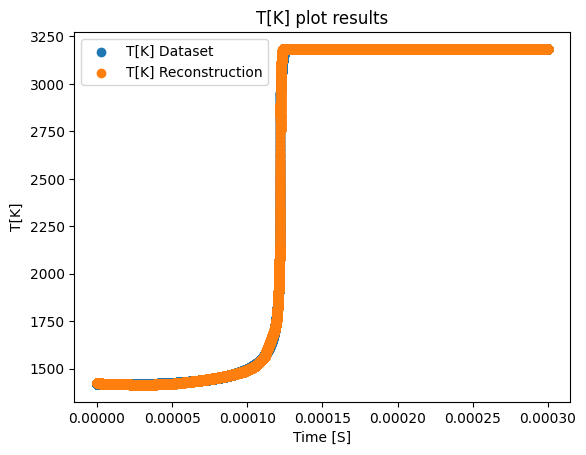

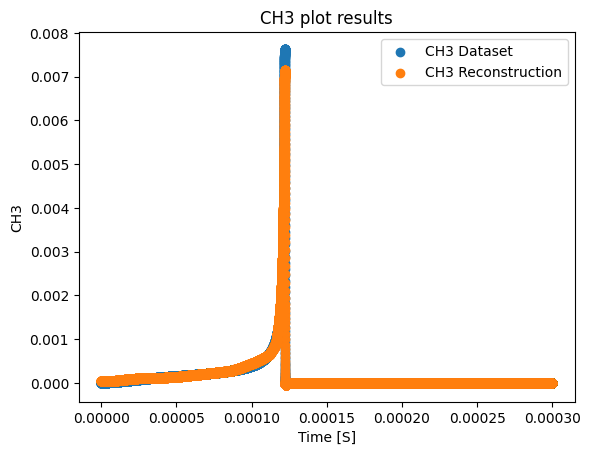

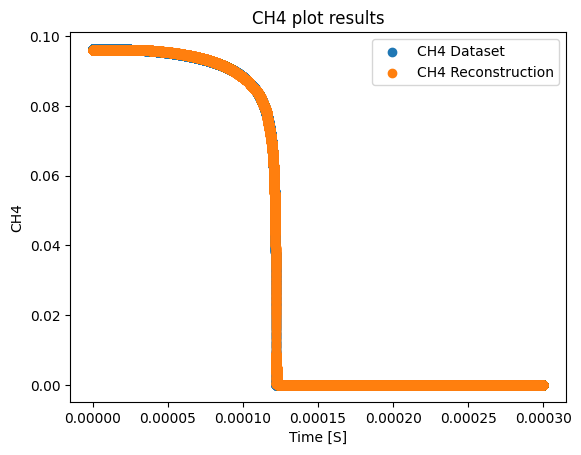

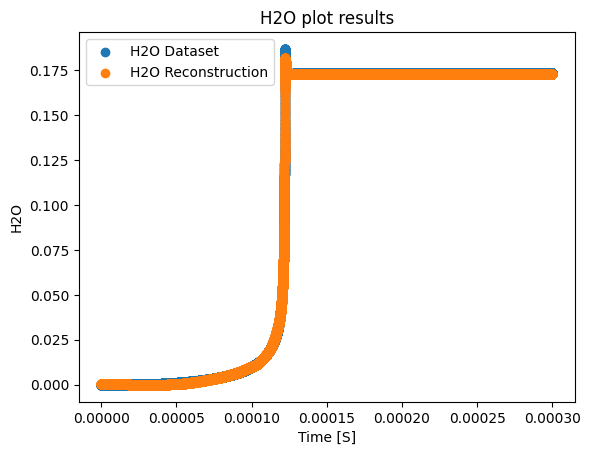

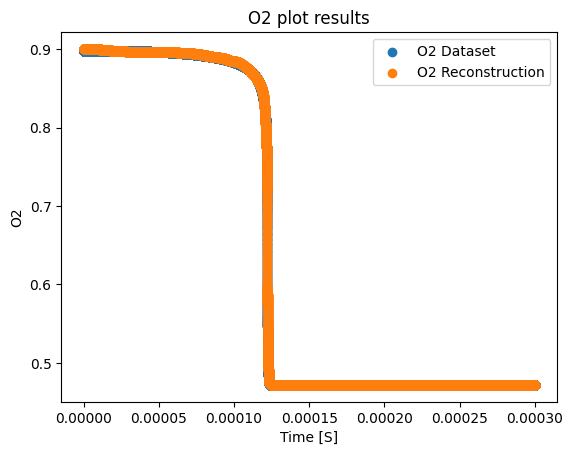

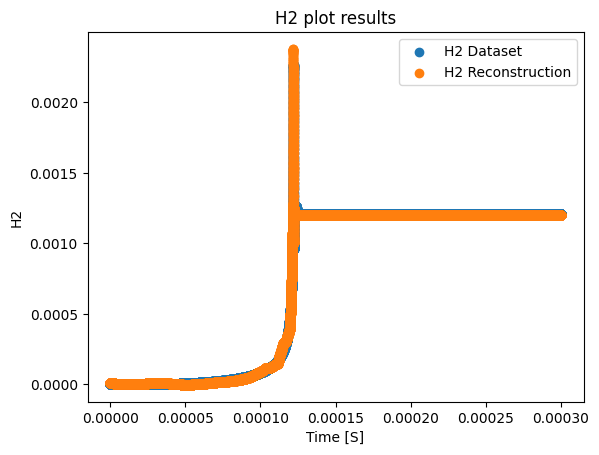

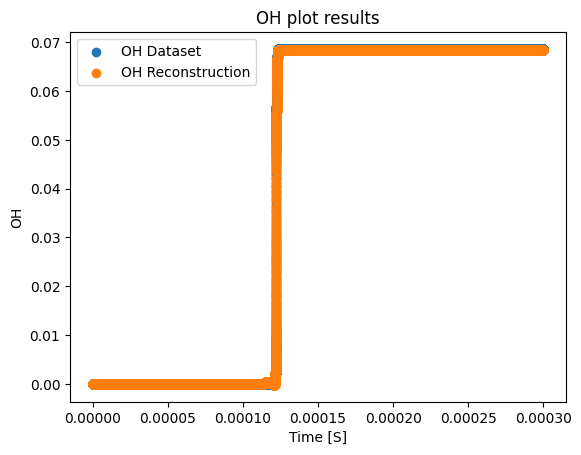

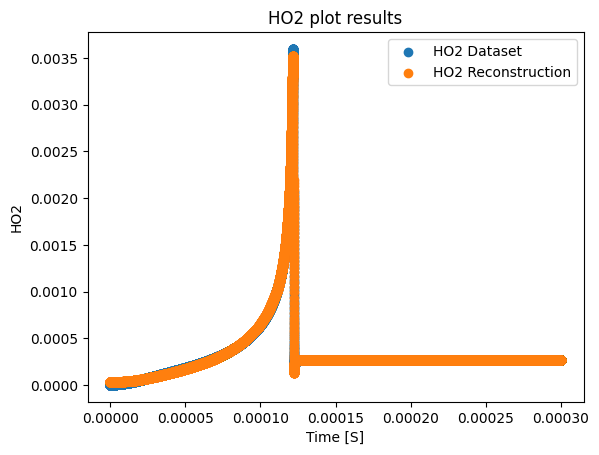

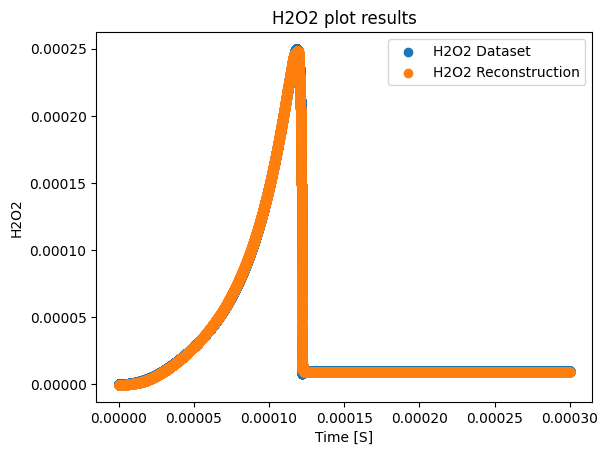

In [9]:
t_index=columns.index('t[s]shift')
t_trans=maximum_values.columns.get_loc('t[s]')
time_plot=(dataset.iloc[:,t_index])*maximum_values.iloc[0,t_trans]
    
for k in range(len(interest_vector)):
    original_index=columns.index(interest_vector[k]+'shift')
    #print(columns[original_index])
    results_index=columns.index(interest_vector[k]) #minues one due to the time column presence 
    #print(columns[results_index])
    #print(results_index-1)
    transformation_index=maximum_values.columns.get_loc(interest_vector[k])
    plot_name=interest_vector[k]+'.png'
    
    input_label=interest_vector[k]+' Dataset'
    output_label=interest_vector[k]+' Reconstruction'
    
    original=(dataset.iloc[:,original_index]).to_numpy()
    #original=original*transformation_values[1,original_index]
    #original=original+transformation_values[0,original_index]
    #original=np.exp(original)-1
    original=original*maximum_values.iloc[0,transformation_index]
    
    output=(results[:,results_index-1])
    #output=output*transformation_values[1,results_index]
    #output=output+transformation_values[0,results_index]
    #output=np.exp(output)-1
    output=output*maximum_values.iloc[0,transformation_index]
    
    plt.figure(k)
    plt.scatter(time_plot,original, label=input_label)
    plt.scatter(time_plot,output, label=output_label)
    plt.title(interest_vector[k]+' plot results')
    plt.xlabel('Time [S]')
    plt.ylabel(interest_vector[k])
    plt.legend()

In [10]:
latent_space=Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy())).numpy()

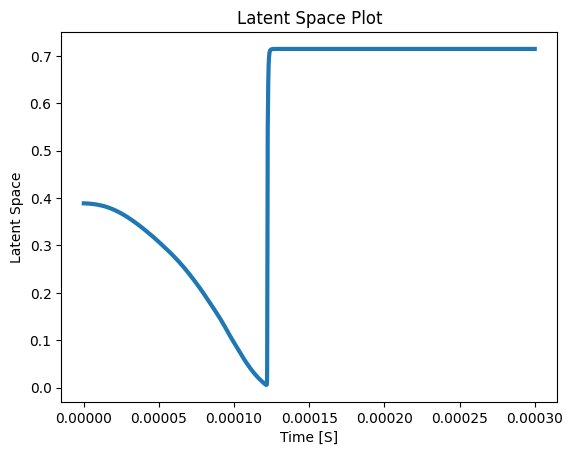

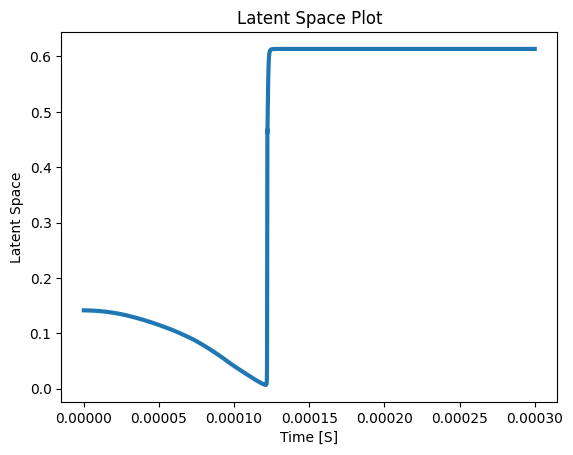

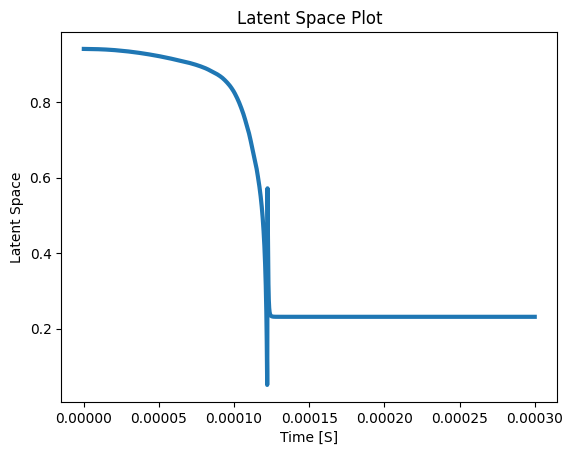

In [11]:
reduced_size=3

if reduced_size==1:
    plt.figure()
    plt.plot(time_plot,latent_space,linewidth=3)
    plt.title('Latent Space Plot')
    plt.xlabel('Time [S]')
    plt.ylabel('Latent Space')
else: 
    for i in range(reduced_size):
            plt.figure(i)
            plt.plot(time_plot,latent_space[:,i],linewidth=3)
            plt.title('Latent Space Plot')
            plt.xlabel('Time [S]')
            plt.ylabel('Latent Space')

In [12]:
corr_dataset=dataset.iloc[:,1:2+n_columns_mass_fraction+n_columns_source]
corr_columns=corr_dataset.columns.to_list()
corr_dataset

,T[K],H2,H,O,O2,OH,H2O,HO2,H2O2,C,...,CH3OHw,C2Hw,C2H2w,C2H3w,C2H4w,C2H5w,C2H6w,HCCOw,CH2COw,HCCOHw
0,0.405009,5.481850e-12,5.886292e-10,2.003150e-11,1.000000,1.121410e-11,8.548106e-14,6.927854e-07,3.850298e-10,1.634157e-36,...,2.528718e-10,1.255491e-29,1.072142e-17,6.178389e-19,7.325638e-09,4.967729e-06,-4.000705e-04,6.546501e-29,5.527620e-29,2.590110e-30
1,0.405009,2.142664e-11,1.135111e-09,7.748934e-11,1.000000,4.381120e-11,6.148399e-13,1.385749e-06,1.539364e-09,5.637104e-33,...,9.726485e-10,2.021252e-28,4.291359e-17,3.691192e-18,1.467402e-08,4.985713e-06,-4.001254e-04,1.829337e-27,1.290080e-27,7.404424e-29
2,0.405009,4.710768e-11,1.642582e-09,1.685712e-10,1.000000,9.625478e-11,1.990925e-12,2.078902e-06,3.462621e-09,2.076380e-32,...,2.104468e-09,1.065155e-27,9.665678e-17,1.070141e-17,2.205229e-08,5.008365e-06,-4.001825e-04,1.294711e-26,8.636509e-27,5.362240e-28
3,0.405009,8.182393e-11,2.114066e-09,2.896614e-10,1.000000,1.670358e-10,4.602206e-12,2.772254e-06,6.154284e-09,-7.352794e-32,...,3.597964e-09,3.363164e-27,1.720515e-16,2.271672e-17,2.946696e-08,5.035067e-06,-4.002416e-04,5.158420e-26,3.394237e-26,2.191673e-27
4,0.405009,1.249319e-10,2.552332e-09,4.374890e-10,1.000000,2.547445e-10,8.805544e-12,3.465812e-06,9.613844e-09,8.509582e-32,...,5.409154e-09,8.220758e-27,2.692158e-16,4.055375e-17,3.692364e-08,5.065258e-06,-4.003026e-04,1.496571e-25,9.837580e-26,6.518154e-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119994,0.909461,8.027937e-02,1.488133e-01,8.007391e-01,0.525223,6.835259e-01,5.003641e-01,7.020777e-02,3.683806e-02,1.880419e-08,...,-9.773431e-23,-1.948438e-25,-2.579638e-26,-1.287121e-29,-3.015748e-31,-8.618409e-34,-4.594265e-36,-1.667075e-23,-2.263384e-24,-2.727582e-25
119995,0.909461,8.027937e-02,1.488133e-01,8.007391e-01,0.525223,6.835259e-01,5.003641e-01,7.020777e-02,3.683806e-02,1.880419e-08,...,-9.957551e-23,-1.879891e-25,-2.593928e-26,-1.272362e-29,-3.064343e-31,-8.702803e-34,-4.397693e-36,-1.657071e-23,-2.265768e-24,-2.708053e-25
119996,0.909461,8.027937e-02,1.488133e-01,8.007391e-01,0.525223,6.835259e-01,5.003641e-01,7.020777e-02,3.683806e-02,1.880419e-08,...,-1.013620e-22,-1.950391e-25,-2.598229e-26,-1.285649e-29,-3.004265e-31,-8.571242e-34,-4.560644e-36,-1.673411e-23,-2.273217e-24,-2.710133e-25
119997,0.909461,8.027937e-02,1.488133e-01,8.007391e-01,0.525223,6.835259e-01,5.003641e-01,7.020777e-02,3.683806e-02,1.880419e-08,...,-1.004704e-22,-1.906621e-25,-2.633635e-26,-1.266837e-29,-3.057429e-31,-8.686595e-34,-4.475059e-36,-1.707776e-23,-2.262646e-24,-2.691260e-25


In [13]:
iterations=np.shape(corr_dataset)[1]

from scipy import stats 

if reduced_size==1:
    corr_indexes=np.zeros(iterations) #rows, columns
    corr_indexes=np.array([corr_indexes])
    
    for j in range(iterations):
        corr_indexes[:,j],_=stats.kendalltau(corr_dataset.iloc[:,j],latent_space)
    corr_indexes=pd.DataFrame(corr_indexes, columns=corr_columns)
else: 
    
    corr_indexes=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            corr_indexes[k,j],_=stats.kendalltau(corr_dataset.iloc[:,j],latent_space[:,k])
    corr_indexes=pd.DataFrame(corr_indexes, columns=corr_columns)

In [14]:
corr_indexes

,T[K],H2,H,O,O2,OH,H2O,HO2,H2O2,C,...,CH3OHw,C2Hw,C2H2w,C2H3w,C2H4w,C2H5w,C2H6w,HCCOw,CH2COw,HCCOHw
0,0.439690,0.325938,0.331039,0.332185,-0.435743,0.340182,0.427351,-0.097844,-0.552718,0.421359,...,-0.803149,-0.819569,-0.821573,-0.821385,-0.809739,-0.817425,-0.023258,-0.816457,-0.816480,-0.822426
1,0.438383,0.331057,0.336168,0.337316,-0.434428,0.345329,0.426020,-0.100239,-0.550771,0.420016,...,-0.802579,-0.817356,-0.820339,-0.819775,-0.809181,-0.816799,-0.021082,-0.814258,-0.814163,-0.820363
2,-0.812916,-0.712833,-0.707998,-0.709084,0.816844,-0.716961,-0.809136,-0.303948,0.153835,-0.814566,...,0.420094,0.415875,0.418535,0.417374,0.425311,0.422903,0.027135,0.410928,0.410602,0.417158


O2w     0.816810
CH4w    0.730269
T[K]    0.439690
CO2     0.435728
H2O     0.427351
Name: 0, dtype: float64
O2w     0.814001
CH4w    0.733942
T[K]    0.438383
CO2     0.434414
H2O     0.426020
Name: 1, dtype: float64
O2      0.816844
CH4     0.708736
CH3w    0.503391
C2H6    0.479770
HO2w    0.427547
Name: 2, dtype: float64


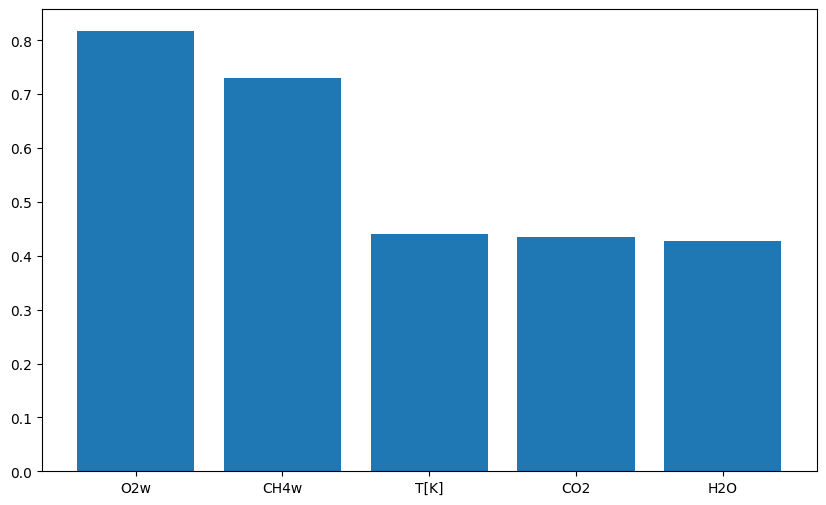

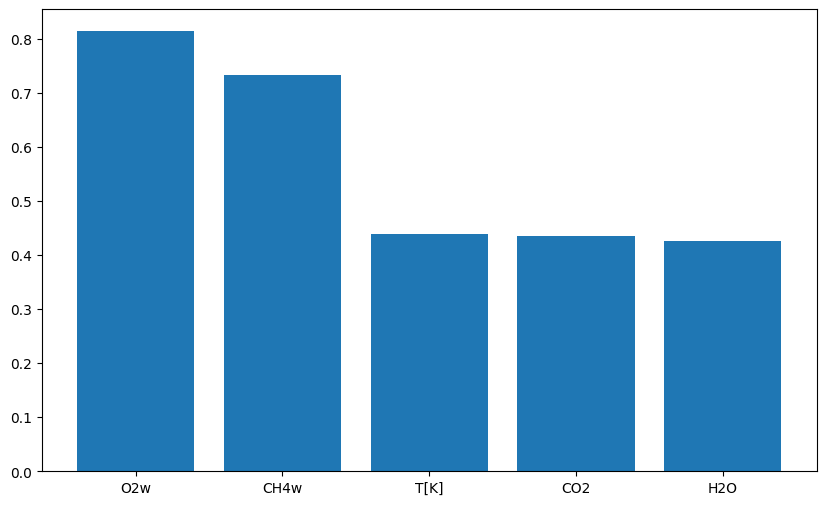

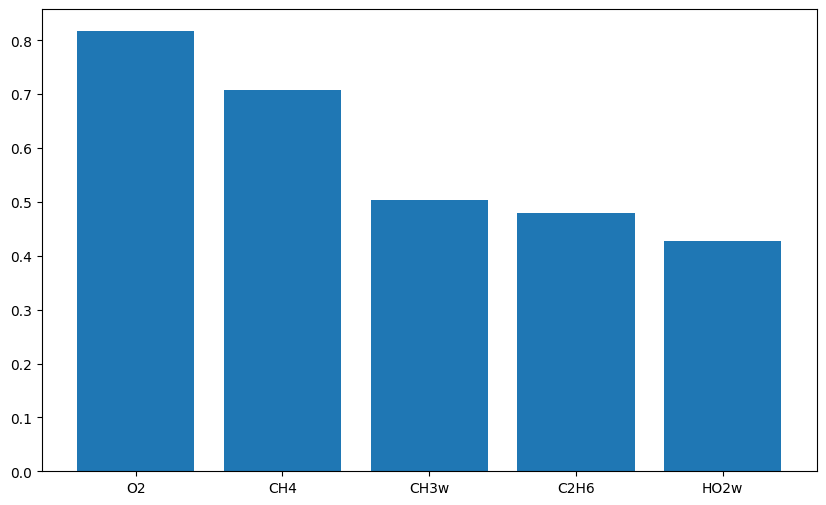

In [15]:
for m in range(reduced_size):
    
    indexes=corr_indexes.iloc[m,:].sort_values(ascending=False)
    indexes=indexes.iloc[0:5]
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)

In [16]:
if reduced_size==1:
    spearman_indexes=np.zeros(iterations) #rows, columns
    spearman_indexes=np.array([spearman_indexes])
    
    for j in range(iterations):
        spearman_indexes[:,j],_=stats.spearmanr(corr_dataset.iloc[:,j],latent_space)
    spearman_indexes=pd.DataFrame(spearman_indexes, columns=corr_columns)
else: 
    
    spearman_indexes=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            spearman_indexes[k,j],_=stats.spearmanr(corr_dataset.iloc[:,j],latent_space[:,k])
    spearman_indexes=pd.DataFrame(spearman_indexes, columns=corr_columns)

In [17]:
spearman_indexes

,T[K],H2,H,O,O2,OH,H2O,HO2,H2O2,C,...,CH3OHw,C2Hw,C2H2w,C2H3w,C2H4w,C2H5w,C2H6w,HCCOw,CH2COw,HCCOHw
0,0.763759,0.671969,0.681331,0.682288,-0.763564,0.688744,0.756515,-0.127880,-0.648370,0.740523,...,-0.879574,-0.902736,-0.901234,-0.901347,-0.885504,-0.895531,-0.016434,-0.899914,-0.898408,-0.903218
1,0.762922,0.677867,0.685461,0.686420,-0.762726,0.692885,0.755941,-0.129006,-0.646408,0.741479,...,-0.880735,-0.901620,-0.901481,-0.901079,-0.886669,-0.896576,-0.015285,-0.898827,-0.897172,-0.902319
2,-0.898610,-0.816997,-0.813042,-0.813996,0.898803,-0.820393,-0.892437,-0.347828,0.257809,-0.896888,...,0.746456,0.737080,0.741321,0.740086,0.750674,0.747239,0.000133,0.733252,0.733605,0.739069


O2w     0.904067
CH4w    0.831232
T[K]    0.763759
CO2     0.763564
H2O     0.756515
Name: 0, dtype: float64
O2w     0.902148
CH4w    0.834320
T[K]    0.762922
CO2     0.762727
H2O     0.755941
Name: 1, dtype: float64
O2       0.898803
CH4      0.813729
CH3w     0.763828
C2H4w    0.750674
CH2Ow    0.747684
Name: 2, dtype: float64


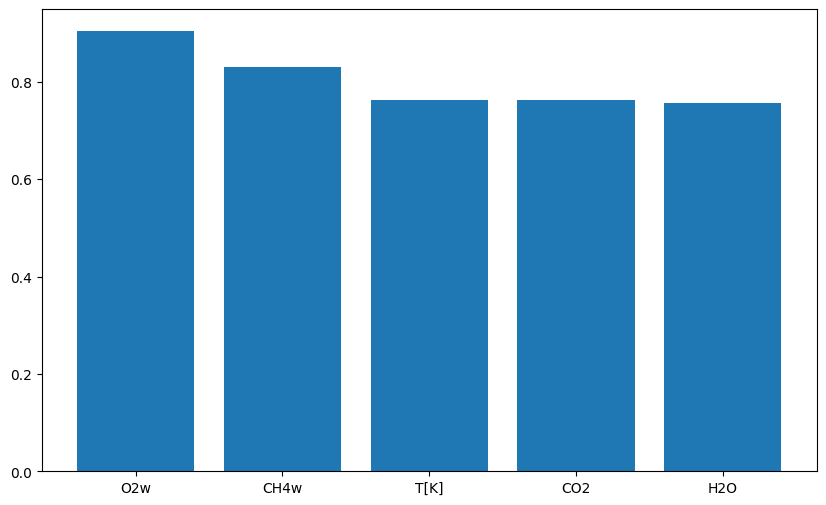

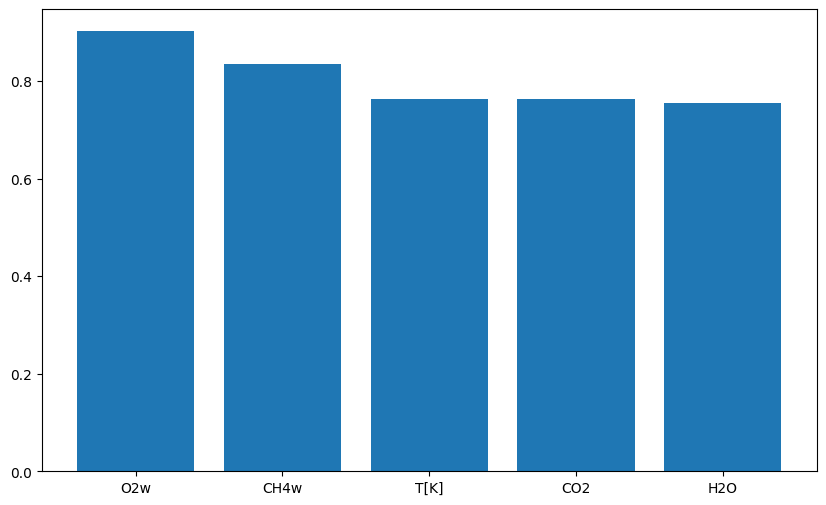

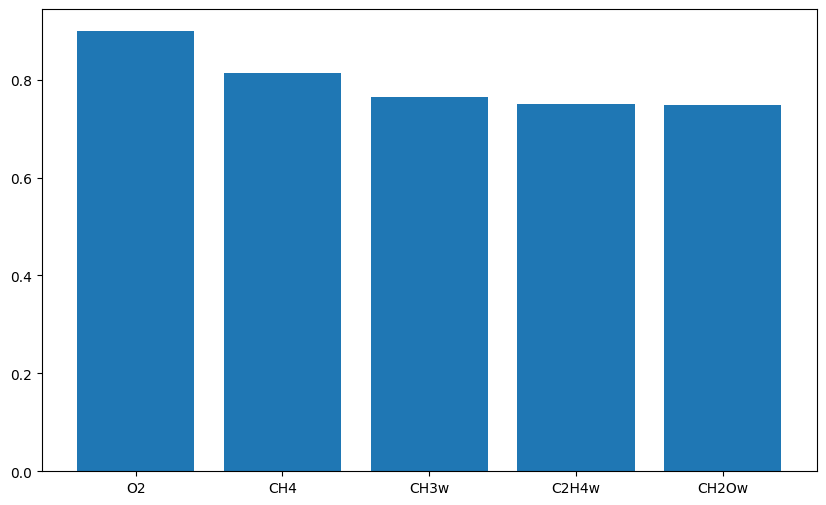

In [18]:
for m in range(reduced_size):
    
    indexes=spearman_indexes.iloc[m,:].sort_values(ascending=False)
    indexes=indexes.iloc[0:5]
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)

In [19]:
n_samples=np.shape(latent_space)[0]

corr_dataset_=corr_dataset.iloc[1:,:]

latent_space_=latent_space[0:n_samples-1,:]

In [20]:
print(np.shape(corr_dataset_))
print(np.shape(latent_space_))

(119998, 61)
(119998, 3)


In [21]:
iterations=np.shape(corr_dataset_)[1]

from scipy import stats 

if reduced_size==1:
    corr_indexes_=np.zeros(iterations) #rows, columns
    corr_indexes_=np.array([corr_indexes_])
    
    for j in range(iterations):
        corr_indexes_[:,j],_=stats.kendalltau(corr_dataset_.iloc[:,j],latent_space_)
    corr_indexes_=pd.DataFrame(corr_indexes_, columns=corr_columns)
else: 
    
    corr_indexes_=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            corr_indexes_[k,j],_=stats.kendalltau(corr_dataset_.iloc[:,j],latent_space_[:,k])
    corr_indexes_=pd.DataFrame(corr_indexes_, columns=corr_columns)

In [22]:
corr_indexes_

,T[K],H2,H,O,O2,OH,H2O,HO2,H2O2,C,...,CH3OHw,C2Hw,C2H2w,C2H3w,C2H4w,C2H5w,C2H6w,HCCOw,CH2COw,HCCOHw
0,0.439685,0.325912,0.331013,0.332159,-0.435740,0.340156,0.427348,-0.097855,-0.552732,0.421356,...,-0.803135,-0.819576,-0.821562,-0.821375,-0.809725,-0.817411,-0.023271,-0.816463,-0.816487,-0.822431
1,0.438379,0.331035,0.336147,0.337294,-0.434426,0.345308,0.426017,-0.100252,-0.550796,0.420013,...,-0.802567,-0.817388,-0.820361,-0.819797,-0.809169,-0.816789,-0.021085,-0.814292,-0.814196,-0.820397
2,-0.812923,-0.712865,-0.707985,-0.709070,0.816849,-0.716948,-0.809188,-0.303942,0.153867,-0.814571,...,0.420107,0.415966,0.418596,0.417434,0.425325,0.422964,0.027157,0.411000,0.410673,0.417230


O2w     0.816829
CH4w    0.730265
T[K]    0.439685
CO2     0.435725
H2O     0.427348
Name: 0, dtype: float64
O2w     0.814024
CH4w    0.733944
T[K]    0.438379
CO2     0.434411
H2O     0.426017
Name: 1, dtype: float64
O2      0.816849
CH4     0.708722
CH3w    0.503453
C2H6    0.479757
HO2w    0.427608
Name: 2, dtype: float64


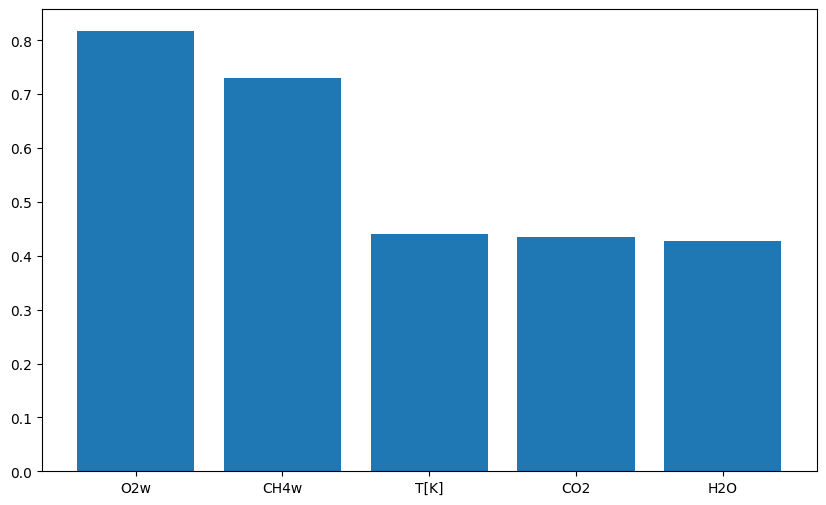

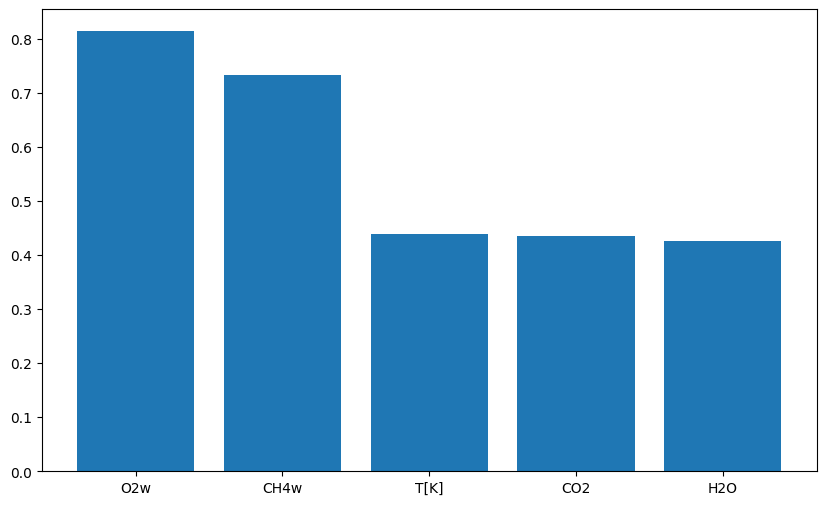

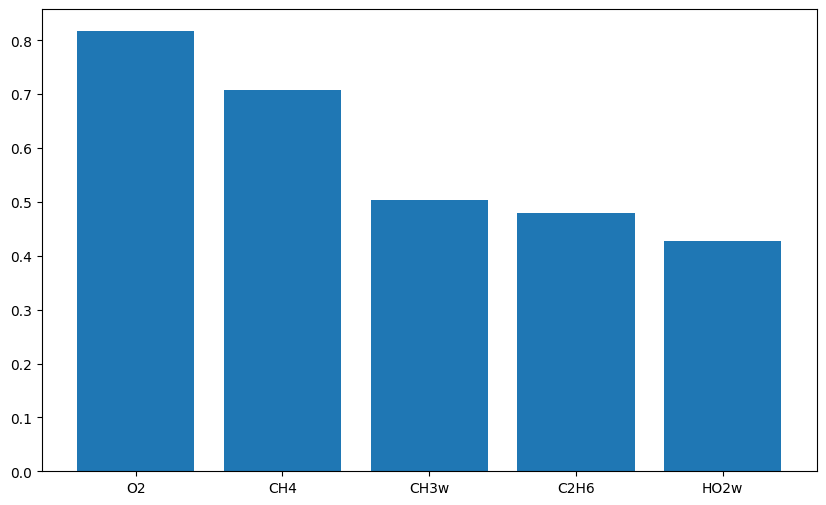

In [23]:
for m in range(reduced_size):
    
    indexes=corr_indexes_.iloc[m,:].sort_values(ascending=False)
    indexes=indexes.iloc[0:5]
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)